# Instalación

**Los datos necesarios para realizar la práctica están en una carpeta compartida que se llama `data`, situada en "Shared with me". Para que el cuaderno pueda acceder a ella es necesario crear un link en "My Drive". El link se crea simplemente seleccionando "data", y desde el menu del botón derecho seleccione "Add a shortcut to Drive".**

**Una vez hecho esto, ejecute la siguiente celda. Esta celda montará el directorio de trabajo del cuaderno y verá la carpeta `data` a través del link. Para montar el directorio le pedirá que se registre en "Drive"**.

In [ ]:
## Instalación: esta celda monta el directorio de trabajo
if 'google.colab' in str(get_ipython()):
    # Setup colab
    from google.colab import drive
    drive.mount('/drive')
    %cd /drive/My Drive/data
else:
    pass

# Regularización

Hasta ahora hemos configurado las redes neuronales concatenando un conjunto de capas densas. Además de las capas `densas` existen multitud de capas que pueden utilizarse en un modelo, como se puede ver en la documentación de [Keras](https://www.tensorflow.org/api_docs/python/tf/keras/layers/). Algunas capas son similares a las `densas` y definen las conexiones entre neuronas, mientras que otras pueden hacer operaciones de preprocesado u otros tipos de transformaciones. En esta práctica trataremos dos tipos de capas especiales: **dropout** y **batchnorm**, las cuales no contienen neuronas, añaden funcionalidad al proceso de entrenamiento a través de la regularización. Ambas son muy utilizadas en las arquitecturas modernas.

## Dropout

La primera de estas capas se llama **dropout** y suele ayudar a corregir el sobreajuste. Como se ha mencionado, el sobreajuste se debe a que la red aprende patrones de ruido en los datos de entrenamiento. La red suele configurar combinaciones muy específicas de pesos para representar el ruido, es una especie de "coordinación" entre pesos que suele basarse en estructuras muy frágiles: si se elimina un peso, la estructura coordinada no funciona. Esta es la idea en la que se basa el **dropout**, romper estas estructuras, para ello eliminamos aleatoriamente una fracción de las neuronas que definen la entrada de una capa en cada paso del entrenamiento, lo que hace mucho más difícil que la red aprenda los patrones de ruido en los datos de entrenamiento. En su lugar, la red debe buscar patrones generales, que no dependan de una sola neurona, cuyas configuraciones de pesos sean robustas frente a cambios locales.

<figura style="padding: 1em;"><center>
<img src="https://i.imgur.com/a86utxY.gif" width="600" alt=""><figcaption style="textalign: center; font-style: italic">Funcionamiento de una red con un 50% de dropout en una capa  oculta.</center></figcaption>
</figura>

En *Keras*, la capa `Dropout` se coloca justo después de la capa de neuronas donde queremos aplicarlo y la tasa de eliminación define el porcentaje de neuronas que se "desconecta" para cada muestra procesada por la red. La tasa de eliminación viene definida por el parámetro `rate`. El ejemplo de la figura anterior viene definido con el siguiente código:

``` python
model = keras.Sequential([
layers.Dense(4, activation='relu', input_shape=[2]),
layers.Dropout(rate=0.3),
layers.Dense(3, activation='relu'),
layers.Dense(1),
])
```

## Normalización por lotes

Los algoritmos de optimización basados en gradiente descendente, en nuestro caso **SGD**, cambian los pesos de la red de forma proporcional al gradiente. El gradiente se calcula respecto de los pesos de todas las capas de la red y depende de lo grandes que sean tanto las salidas intermedias (activaciones de la red) como los datos de entrada. Si los datos de entrada tienden a producir activaciones de tamaños muy diferentes, pueden hacer que los errores provocados por la pérdida de precisión numérica hagan que el entrenamiento sea inestable. Por un lado es bueno normalizar los datos antes de que entren en la red, por otro lado suele ser bueno normalizar el flujo de datos (activaciones) dentro de la red. En general, suele ser buena idea realizar una normalización de los datos de entrada, por ejemplo con [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) o [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) del paquete de *Machine Learning* `scikit-learn`. Por otro lado, la normalización por lote es una técnica que se aplica dentro de la red. En *Keras* se puede configurar con la capa `BatchNormalization`, y puede ayudar a corregir el entrenamiento que resulta lento o inestable. Esta capa realiza las siguientes operaciones: 
- en primer lugar examina en cada batch las entradas en una determinada capa de la red y normaliza los datos con su propia media y desviación estándar.
- Después configura los datos con una nueva escala, que viene definida por una nueva media y desviación, los cuales se configuran como parámetros entrenables por la red.

Es decir, el proceso de **Batchnorm** realiza un re-escalado automático en los datos a lo largo de la red que favorecen el entrenamiento, y por tanto el funcionamiento de la propia red. Generalmente el **Batchnorm** se añade como una ayuda al proceso de optimización y contribuye a reducir el número de épocas de entrenamiento, incluso puede evitar que el entrenamiento se "atasque" por problemas en la precisión numérica en la representación de los datos. A veces también puede mejorar el rendimiento en modo de predicción. El **Batchnorm** puede utilizarse en casi cualquier punto de una red, por ejemplo después de una capa:

``` python
layers.Dense(16, activation='relu'),
layers.BatchNormalization(),
```

o entre una capa y su función de activación:

``` python
layers.Dense(16),
layers.BatchNormalization(),
layers.Activation('relu'),
```

Si se añade como la primera capa de la red, puede actuar como una especie de preprocesado adaptativo.

## Ejemplo

Volvemos al modelo usado con la base de datos "*Red Wine*". En este caso aumentaremos más la capacidad de la red, pero añadiremos el **Dropout** para controlar el sobreajuste y el **Batchnorm** para acelerar la optimización. En la sesión anterior, cuando usamos esta base de datos realizamos una etapa de preprocesado para su normalización. En esta ocasión prescindimos de dicha normalización, con el objetivo de demostrar la capacidad del **Batchnorm** para la estabilización del entrenamiento.

En primer lugar importamos las librerías:

In [2]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

Cargamos la base de datos y generamos dos conjuntos, el de entrenamiento y el de validación, sin normalización.

In [3]:
# Create training and validation splits
red_wine = pd.read_csv('data_m3/datasets/red-wine.csv')
df_train = red_wine.sample(frac=0.7, random_state=0)
df_valid = red_wine.drop(df_train.index)

# Scale to [0, 1]
#max_ = df_train.max(axis=0)
#min_ = df_train.min(axis=0)
#df_train = (df_train - min_) / (max_ - min_)
#df_valid = (df_valid - min_) / (max_ - min_)

# Split features and target
X_train = df_train.drop('quality', axis=1)
X_valid = df_valid.drop('quality', axis=1)
y_train = df_train['quality']
y_valid = df_valid['quality']

Al añadir el **dropout**, podemos aumentar el número de neuronas en las capas, en este caso utilizamos capas con 1024 neuronas.

In [11]:
model = keras.Sequential([
    layers.Dense(1024, activation='relu', input_shape=[11]),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1),
])

Mantenemos la misma configuración del entrenamiento.

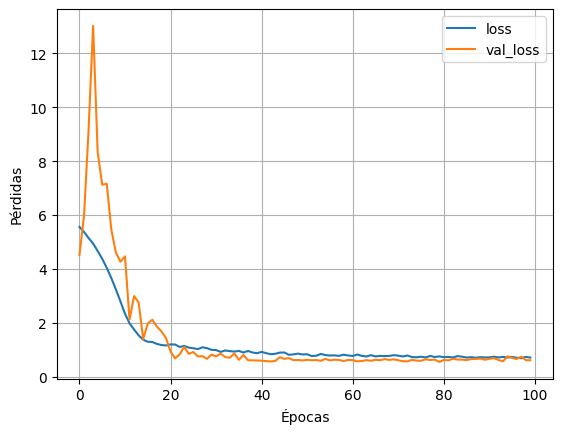

In [5]:
model.compile(
    optimizer='adam',
    loss='mae',
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=100,
    verbose=0,
)

# Show the learning curves
history_df = pd.DataFrame(history.history)
ax = history_df.loc[:, ['loss', 'val_loss']].plot();
ax.set(xlabel='Épocas', ylabel='Pérdidas'),plt.grid();
plt.show()

# Clasificación binaria 

Hasta ahora hemos tratado problemas de regresión para predecir variables numéricas. En esta sección aplicamos las redes neuronales a otro problema común de aprendizaje automático: la clasificación. La diferencia principal con la regresión es la función de pérdidas utilizada en el entrenamiento y el tipo de salidas de la última capa. La clasificación binaria es un problema muy común en el aprendizaje automático: se puede predecir si es probable que un cliente haga una compra, si una transacción con tarjeta de crédito fue fraudulenta, si una prueba médica evidencia una enfermedad...

Cuando trabajamos con datos brutos, las clases pueden estar representadas por etiquetas como "Sí" y "No", o "Perro" y "Gato". Antes de utilizar estos datos, es necesario asignar una **etiqueta de clase** numérica: una clase será `0` y la otra será `1`, de este modo permitimos que la red pueda interpretar la información de forma numérica.

## Función de pérdidas y métrica

En los problemas de regresión, el proceso de entrenamiento está basado en la minimización de una métrica de error que suele ser el error absoluto medio (MAE) o el error cuadrático medio (MSE). En problemas de clasificación, el objetivo suele ser la **precisión** en la clasificación (Accuracy), definida como la relación entre el número de predicciones correctas y las predicciones totales: `precisión = respuestas_correctas / total`. Esta métrica es fácilmente interpretable, por ejemplo, un modelo que es capaz de predecir correctamente tendría una **precisión** de `1.0`. El problema de la precisión (y de la mayoría de las métricas de clasificación) es que no puede utilizarse como función de pérdidas en el proceso de entrenamiento, ya que al ser una proporción de sucesos, un cambio en un suceso es un salto en la función. Sin embargo, el SGD está basado en el cálculo del gradiente, y por tanto necesita que la función de pérdidas cambie suavemente. Por tanto, para esta nueva aplicación necesitamos otra función de pérdidas: una de las más utilizadas es la **entropía cruzada**. La **entropía cruzada** mide la distancia entre la distribución de probabilidad de que ocurra un suceso y la probabilidad de que ocurra el suceso contrario (binario). Por ejemplo, si queremos que la red prediga la clase correcta con probabilidad `1.0`, cuanto más lejos esté de `1.0` mayor será la pérdida de la **entropía cruzada**, como se puede ver en la siguiente gráfica:    

<figura style="padding: 1em;">
<center><img src="https://i.imgur.com/DwVV9bR.png" width="400" alt="">
<figcaption style="textalign: center; font-style: italic">La entropía cruzada penaliza la probabilidad de predicciones incorrectas.</center></figcaption>
</figura>

Aunque usemos la **entropía cruzada** como función de pérdidas en el proceso de entrenamiento, también se suele usar la **precisión** para describir la capacidad de predicción de la red. Al contrario que la función de pérdidas, la precisión es una métrica intuitiva y fácilmente interpretable, por eso se suelen visualizar las dos en paralelo. 

Tanto la **entropía cruzada** como la **precisión** requieren que la red genere como salida un valor de probabilidad, es decir, números de `0` a `1`. Para convertir las salidas producidas por una capa en valores de probabilidad, necesitamos un nuevo tipo de función de activación acotada entre `0` y `1`, la **función de activación sigmoide**, que será el tipo de activación de la última capa de la red. 

<figura style="padding: 1em;">
<center><img src="https://i.imgur.com/FYbRvJo.png" width="400" alt=""></center>
<figcaption style="textalign: center; font-style: italic"><center>La función sigmoide realiza una correspondencia entre un número real arbitrario y otro que está obligatoriamente en el intervalo [0, 1], además, tiene asíntotas horizontales en 0 a la izquierda y 1 a la derecha.</center></figcaption>
</figura>

Para obtener la predicción final de la clase, definimos un *umbral* de probabilidad. Un umbral típico para definir la clase correcta es `0.5`: por debajo de `0.5` se define la clase con etiqueta `0` y por encima de `0.5` se define la clase con etiqueta `1`. Un umbral de `0.5` es lo que *Keras* utiliza por defecto en su [métrica de precisión](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/BinaryAccuracy).

## Ejemplo

El conjunto de datos [Ionosphere](https://archive.ics.uci.edu/ml/datasets/Ionosphere) contiene características de señales de radar que se propagan por la ionosfera de la atmósfera terrestre. La tarea consiste en determinar si la señal muestra la presencia de algún objeto, o es simplemente aire. 

In [6]:
ion = pd.read_csv('data_m3/datasets/ion.csv', index_col=0)
display(ion.head())

df = ion.copy()
df['Class'] = df['Class'].map({'good': 0, 'bad': 1})

df_train = df.sample(frac=0.7, random_state=0)
df_valid = df.drop(df_train.index)

max_ = df_train.max(axis=0)
min_ = df_train.min(axis=0)

df_train = (df_train - min_) / (max_ - min_)
df_valid = (df_valid - min_) / (max_ - min_)
df_train.dropna(axis=1, inplace=True) # drop the empty feature in column 2
df_valid.dropna(axis=1, inplace=True)

X_train = df_train.drop('Class', axis=1)
X_valid = df_valid.drop('Class', axis=1)
y_train = df_train['Class']
y_valid = df_valid['Class']

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V26,V27,V28,V29,V30,V31,V32,V33,V34,Class
1,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,good
2,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,bad
3,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,good
4,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,bad
5,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,good


Definiremos nuestro modelo igual que lo hicimos en las tareas de regresión, con una excepción: en la última capa queremos que la red prediga un valor de probabilidad, que tiene que estar entre 0 y 1. Como hemos comentado, la función de activación **sigmoide** tiene la propiedad de convertir cualquier entrada en una salida situada entre 0 y 1, lo cual será interpretado como una probabilidad de clase.

In [7]:
model = keras.Sequential([
    layers.Dense(4, activation='relu', input_shape=[33]),
    layers.Dense(4, activation='relu'),    
    layers.Dense(1, activation='sigmoid'),
])

Configuramos el entrenamiento con el método `compile`, utilizamos la función de pérdidas de **entropía cruzada** y pedimos a Keras que nos muestre el valor de la **precisión** (Accuracy) en el conjunto de validación, de este modo podemos visualizar la evolución de la tasa de errores cometidos. En el caso de tener dos clases se dice que es un problema binario, esto explica el nombre de las métricas: **binary_crossentropy** y **binary_accuracy**. Para problemas con más clases tendremos que modificar la función de pérdidas y la métrica de validación. El optimizador **Adam** funciona muy bien para la clasificación, por tanto lo mantenemos.

In [8]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

El modelo de este problema puede tardar bastantes épocas en completar el entrenamiento, por lo que incluiremos un `callback` de parada temprana.

In [9]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.0005,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=32,
    epochs=150,
    callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
)

Como siempre, es interesante visualizar las curvas de aprendizaje y los valores de las **pérdidas** y la **precisión** que obtuvimos en el conjunto de validación (note que la parada temprana restaurará los pesos a la mejor situación).

Best Validation Loss: 0.4062
Best Validation Accuracy: 0.8857


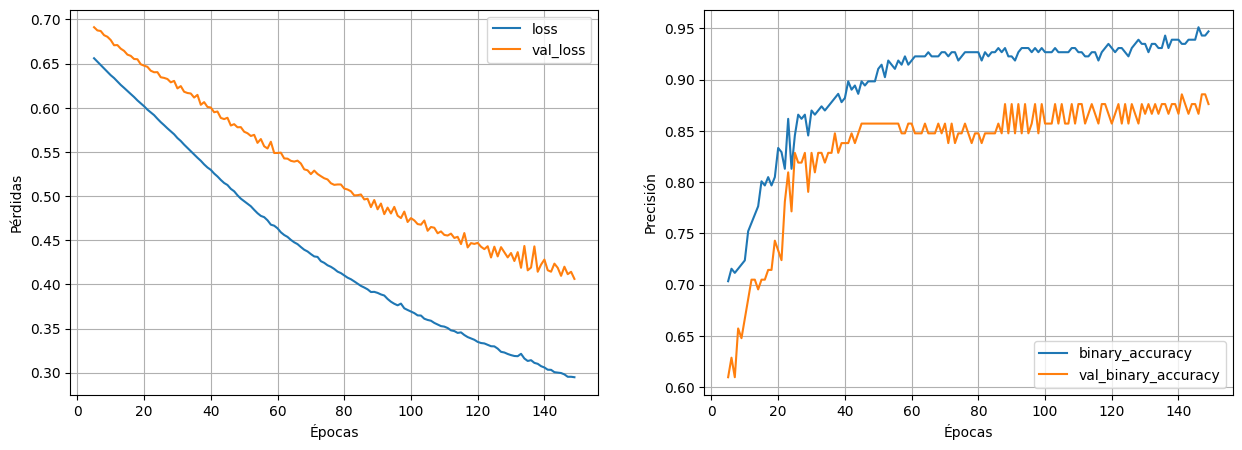

In [10]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 5))
history_df.loc[5:, ['loss', 'val_loss']].plot(xlabel='Épocas', ax=ax1, grid=True)
ax1.set(xlabel='Épocas', ylabel='Pérdidas')
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot(xlabel='Épocas',ax=ax2, grid=True);
ax2.set(xlabel='Épocas', ylabel='Precisión')

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

Obsérvese que hemos conseguido una precisión aproximada de 90%.